<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/02_neural_network_cancer_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn import metrics


from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
"""
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

import tensorflow
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import metrics
"""

'\nfrom sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV\n\nimport tensorflow\nimport keras\n\nfrom keras.models import Sequential\nfrom keras.layers import Dense\nfrom keras.wrappers.scikit_learn import KerasClassifier\n\nfrom sklearn import metrics\n'

# **Descripcion**
---



Utilizando el conjunto de datos de supervivencia de cancer se plicara cross validation, Wrapper, Optimización de hiperparametros

# **Objetivo**
---
Predecir pacientes con más posibilidades de morir.


# **Dicionario de datos**
---
Conjunto de datos de supervivencia de Haberman

- `Age`: Edad del paciente en el momento de la operación 
- `Year`: Año de operación del paciente 
- `Nodes`: Número de ganglios axilares positivos detectados
- `status`: Estado de supervivencia
-- 1  paciente sobrevivió 5 años o más
-- 2  paciente murió dentro de los 5 años


# **Data**
---



In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv', header = None, names=['age', 'year', 'node', 'status'])
data.head(5)

,age,year,node,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     306 non-null    int64
 1   year    306 non-null    int64
 2   node    306 non-null    int64
 3   status  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


- Todas las variables son de tipo numerico
- No hay valores nulos

# **Split**
---

In [5]:
data_values = data.values
X = data_values[:, :3]
y = data_values[:, 3]

In [6]:
def plot_bars(data: np.ndarray, title: str= 'feature', x_size:int=6, y_size:int=4, font_size:int=15, 
              x_label:str='churm', y_label:str='no churm')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax)
  label, data_target = np.unique(data, return_counts=True)
  len_data = data.shape[0]
  pe = '{0:.2f}'.format(data_target[1]/len_data)
  ps = '{0:.2f}'.format(data_target[0]/len_data)
  x_l = list(ax.get_xticklabels())
  if x_l[0].get_text() == label[0]:
    ax.set_xticklabels([f'{ax.get_xticklabels()[0].get_text()}\n{ps}', f'{ax.get_xticklabels()[1].get_text()}\n{pe}'])
  elif x_l[0].get_text() == label[1]:
    ax.set_xticklabels([f'{ax.get_xticklabels()[0].get_text()}\n{pe}', f'{ax.get_xticklabels()[1].get_text()}\n{ps}'])
  ax.set(xlabel=x_label, ylabel=y_label)
  fig.show()

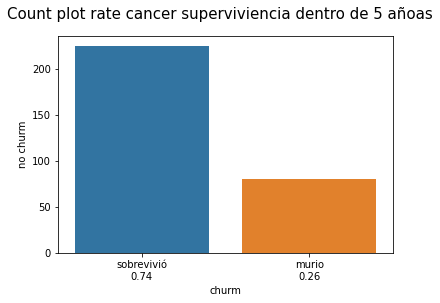

In [7]:
plot_bars(np.where(y==1, 'sobrevivió', 'murio'), title = 'rate cancer superviviencia dentro de 5 añoas')

Hay un serio desbalance en el conjunto de datos del 74% registros son para los pacientes que vivieron y 26% son los pacientes que murireron.


In [8]:
y = np.where(y==1, 0, 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1234, shuffle=True, stratify=y)

- Como las categorías se encuentran desbalanceadas, se procede a realizar una partición estratificada.

# **Model**
---

## **Model Base**
---

In [10]:
def model_base():
  model = Sequential()
  model.add(Dense(10, input_dim = 3, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam')
  return model

In [11]:
model = model_base()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 300, batch_size=5, verbose = 0)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


# **Curvas de aprendizaje de optimización model base**
---

In [13]:
def optimization_learning_curves(history, metrica, title: str= '', x_size:int=8, y_size:int=4, font_size:int=15, x_label:str='Epoch',y_label:str='Loss')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(title, fontsize = font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(x_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper left', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()

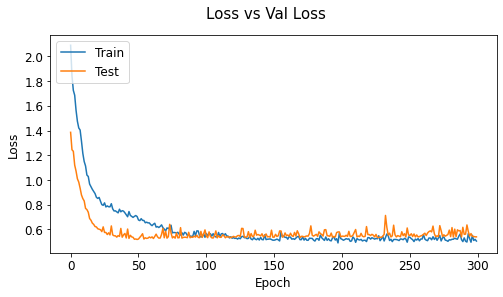

In [14]:
optimization_learning_curves(history, metrica='loss', title='Loss vs Val Loss')

La perdida de entrenamiento y validación disminuyen hasta el punto de estabilida durante 300 epocas, con una brecha de generailización casi inperceptible.

# **Prediction**
---

In [15]:
y_pred = (model.predict(X_test)>0.5).astype('int32')
y_pred = np.reshape(y_pred, y_pred.shape[0])
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [16]:
def consufion_matrix(validation: np.ndarray, prediction:np.ndarray, title: str= 'Matriz de confusion', x_size:int=6, y_size:int=5, **kwards)->np.ndarray:
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows= 1, ncols=  1, figsize = (x_size,y_size))
  sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size': 13})
  ax.set_title(title, size = 13)
  v = list(kwards.values())
  k = list(kwards.keys())
  if ax.get_xticklabels()[0].get_text() == v[0]:
    ax.xaxis.set_ticklabels([k[0], k[1]])
    ax.yaxis.set_ticklabels([k[0], k[1]])
  else:
    ax.xaxis.set_ticklabels([k[1], k[0]])
    ax.yaxis.set_ticklabels([k[1], k[0]])
  ax.tick_params(labelsize = 13)
  fig.show()
  return matrix

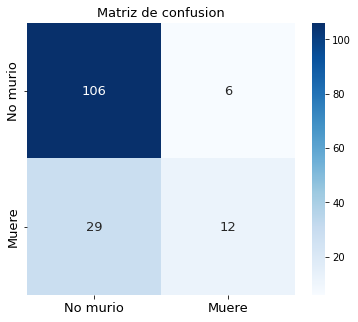

In [17]:
matrix = consufion_matrix(y_test, y_pred, **{'Muere':1, 'No murio':0})

- A partir de la matriz, el modelo tiene problemas para  detectar pacientes con posibilidades de morir en 5 años, ya que hay pocos verdaderos positivos.

In [20]:
# Metricas
def metricas(validation: np.ndarray, prediction:np.ndarray, matrix:np.ndarray, label:list=[1])->None:
  accuracy = '%.3f' % metrics.accuracy_score(validation, prediction)
  kappa = '%.3f' % metrics.cohen_kappa_score(validation, prediction)
  precision = '%.3f' % metrics.precision_score(validation, prediction, labels=label, average="macro")
  recall = '%.3f' % metrics.recall_score(validation, prediction, labels=label, average="macro")
  f1_score = '%.3f' % metrics.f1_score(validation, prediction, labels=label, average="macro")

  print(f'Accuracy  :   {accuracy}')
  print(f'Kappa     :   {kappa}')
  print(f'predicción enfermos')
  print(f'Precision:   {precision}')
  print(f'Recall    :   {recall}')

  VN, FP = 0, 0 
  if label == [1]:
    VN = matrix[0,0]
    FP = matrix[0,1]
  else:
    VN = matrix[0,0]
    FP = matrix[0,1]
  specificity = VN/(VN+FP)
  specificity = '%.3f' %  specificity

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {f1_score}')
  return accuracy, kappa, precision, recall, f1_score, specificity

In [21]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(y_test, y_pred, matrix)

Accuracy  :   0.771
Kappa     :   0.291
predicción enfermos
Precision:   0.667
Recall    :   0.293
Specificity:   0.946
F1-score   :   0.407


- La sensibilidad es pesima, el conjunto de datos es muy pequeño el modelo no es el indicado, cabe resaltar que no se ha tratado la red, ya que la idea es experimentar con datos.

In [23]:
y_prob = model.predict(X_test)
pos_prob = np.reshape(y_prob, y_prob.shape[0])

In [24]:
def precision_recall(y:np.ndarray, prediction_prob:np.ndarray, validation:np.ndarray)->float:
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  precision, recall, _ = metrics.precision_recall_curve(validation, prediction_prob)
  plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  auc_score = metrics.auc(recall, precision)
  plt.show()
  return auc_score

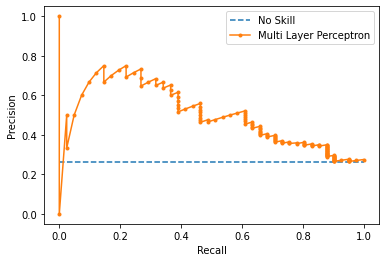

In [25]:
auc_score = precision_recall(y, pos_prob, y_test)

In [26]:
print('Multi Layer Perceptron PR AUC: %.3f' % auc_score)

Multi Layer Perceptron PR AUC: 0.492


- Acorde al area bajo la curva entre la precisión y la sensibilidad es pesimo no superando el modelo **sin habilidad**
- Es posible que con más datos y una estructura más amplia el modelo pueda mejorar su capacidad de predicción para detectar pacientes con diabetes.
- No se ha estandarizado los datos, puede que tambien influya .

# **Cross Validation**
---

In [36]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

cv_score_loss_train = []
cv_score_loss_test = []


for train, test in kfold.split(X, y):
  model = model_base()
  model.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs = 300, batch_size=5, verbose = 0)
  loss_train = model.evaluate(X[train], y[train], verbose=0)
  loss_test = model.evaluate(X[test], y[test], verbose=0)
  cv_score_loss_train.append(loss_train)
  cv_score_loss_test.append(loss_test)
  print('======================================================================')
  print('loss: %.3f val loss test: %.3f' % (loss_train * 100, loss_test * 100))


loss: 53.680 val loss test: 61.676
loss: 49.311 val loss test: 51.487
loss: 51.809 val loss test: 59.861
loss: 57.230 val loss test: 56.795
loss: 54.819 val loss test: 45.069
loss: 56.628 val loss test: 64.076
loss: 53.421 val loss test: 60.358
loss: 49.594 val loss test: 67.797
loss: 53.369 val loss test: 46.652
loss: 53.508 val loss test: 56.751


- Los valores de pérdida de entrenamiento y validación tienden a converger, pese a que el no valor es bajo.
- El mmodelo pese a que no es el mejor para el problema que enfrenta, no se ve afectado por la varianza, aunque puede estar sesgado por la falta de datos.

In [38]:
print('============================== 10 Pliegues ==============================')
print('============================== Loss Train ==============================')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_score_loss_train)*100, np.std(cv_score_loss_train)*100))
print('============================== Loss Test ==============================')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_score_loss_test)*100, np.std(cv_score_loss_test)*100))

============================== 10 Pliegues ==============================
============================== Loss Train ==============================
53.34% (+/- 2.47%)
============================== Loss Test ==============================
57.05% (+/- 6.98%)


- La dispersión como la medida de la perdida tanto en entrenamiento, como en validación no se ven afectado por ruido estadistico es demasiado bajo, es confiable, pese a que la perdida tiene un valor que si bien no es alto, tampoco es bajo. Ademas de evidenciar que el modelo no tiende a un sobreajuste. 

- `El modelo bajo la metrica de optimización y rendimiento seleccionadas, no se considera un modelo excelente para detectar el cancer de corazon, es necesario mirar que otras tecnia se pueden aplicar.`



# **Wrapper**
---

In [40]:
def model_optimizer(optimizer = 'rmsprop', init = 'glorot_uniform'):
  model = Sequential()
  model.add(Dense(10, input_dim = 3, activation='relu', kernel_initializer=init))
  model.add(Dense(1,  activation='sigmoid', kernel_initializer=init))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [ ]:
model = KerasClassifier(build_fn=model_optimizer, epochs=300, batch_size = 5, verbose = 0)

In [45]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
result = cross_val_score(model, X, y, cv = kfold)

- Los resultados no parecen ser tan alejados los unos de los otros, el modelo tiende a converger, poco ruido, pero no es el más indicado para la detección de cancer o falta más datos.

In [46]:
result.mean()*100, result.std()*100

(74.8064512014389, 4.80852009962966)

- La media es confiable, ya que la **dispersión no es tán prolongada**.


# **Optimización de hiperparametros**
---

In [ ]:
model_optimizer = KerasClassifier(build_fn=model_optimizer, verbose = 0)

In [50]:
optimizer = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform', 'he_normal']
epochs = [100, 150, 200]
batch = [5, 10, 15]
param_grid = dict(optimizer = optimizer, epochs = epochs, batch_size = batch, init = init)
grid = GridSearchCV(estimator=model_optimizer, param_grid=param_grid, refit = True, return_train_score=True, cv = 3)

In [51]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7f632c7ed0>,
             param_grid={'batch_size': [5, 10, 15], 'epochs': [100, 150, 200],
                         'init': ['glorot_uniform', 'normal', 'uniform',
                                  'he_normal'],
                         'optimizer': ['rmsprop', 'adam']},
             return_train_score=True)

In [52]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.751634 usando {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}


In [53]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, std, param in zip(means, stds, params):
  print('%f (%f) con %r' % (mean, std, param))

0.712418 (0.088175) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.751634 (0.088175) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.705882 (0.084716) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'rmsprop'}
0.718954 (0.092432) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'adam'}
0.732026 (0.102928) con {'batch_size': 5, 'epochs': 100, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.712418 (0.088175) con {'batch_size': 5, 'epochs': 100, 'init': 'uniform', 'optimizer': 'adam'}
0.686275 (0.083189) con {'batch_size': 5, 'epochs': 100, 'init': 'he_normal', 'optimizer': 'rmsprop'}
0.725490 (0.069785) con {'batch_size': 5, 'epochs': 100, 'init': 'he_normal', 'optimizer': 'adam'}
0.732026 (0.064703) con {'batch_size': 5, 'epochs': 150, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.738562 (0.093808) con {'batch_size': 5, 'epochs': 150, 'init': 'glorot_uniform', 'optim

In [54]:
model_final = grid.best_estimator_
model_final.get_params()

{'batch_size': 5,
 'build_fn': <function __main__.model_optimizer>,
 'epochs': 100,
 'init': 'glorot_uniform',
 'optimizer': 'adam',
 'verbose': 0}

#**Prediction**
---

In [55]:
y_pred = model_final.predict(X_test)

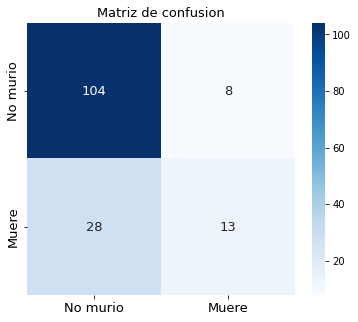

In [57]:
matrix = consufion_matrix(y_test, y_pred, **{'Muere':1, 'No murio':0})

In [58]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(y_test, y_pred, matrix)

Accuracy  :   0.765
Kappa     :   0.291
predicción enfermos
Precision:   0.619
Recall    :   0.317
Specificity:   0.929
F1-score   :   0.419


- El modelo optimizado tiene una mejora casi imperceptible en la sensibilidad para la detección de casos con cancer, aunque la metrica no tiene un rendimiento alto para un caso tán critico como la detección de una enfermedad, ademas sigue teniendo un porcentaje de error tipo 2, demasiados falsos negativos.

In [59]:
pos_prob = model_final.predict_proba(X_test)

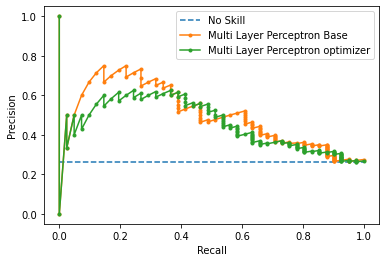

In [60]:
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = metrics.precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron Base')
auc_score_normal = metrics.auc(recall, precision)
precision, recall, _ = metrics.precision_recall_curve(y_test, pos_prob[:,1])
plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron optimizer')
auc_score_optimizer = metrics.auc(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [65]:
print('Multi Layer Perceptron Normal PR AUC: %.3f' % auc_score_normal)
print('Multi Layer Perceptron Optimizer PR AUC: %.3f' % auc_score_optimizer)

Multi Layer Perceptron Normal PR AUC: 0.492
Multi Layer Perceptron Optimizer PR AUC: 0.451


- El modelo `optimizado` no tiene un rendimiento deseado, incluso el modelo `base` lo supera, ya que no logra tener una compensasión ideal entre la precisión y el recall. La causa pueden ser muchas, más falta de datos, una estructura ineficiente, puede que las redes neuronales no sean un modelo indicado, más experimentos en la optimización de parametros, entre otros.

